# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchaudio.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [3]:
audios="/content/drive/MyDrive/Datasets/saved_files.csv"

In [9]:
df=pd.read_csv(audios)
df.head()

,Dataset,Emotion,File
0,CREMA-D,Disgust,1079_IWW_DIS_XX
1,CREMA-D,Disgust,1079_TIE_DIS_XX
2,CREMA-D,Fearful,1080_IOM_FEA_XX
3,CREMA-D,Neutral,1080_TAI_NEU_XX
4,CREMA-D,Sad,1079_TAI_SAD_XX


In [10]:
base_audio_path = "/content/drive/MyDrive/Datasets/Processed_Audio"
df["Path"] = df.apply(lambda row: f"{base_audio_path}/{row['Dataset']}/{row['Emotion']}/{row['File']}.pt", axis=1)


# Encoding

In [11]:
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Emotion"])
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_map)


{'Angry': np.int64(0), 'Disgust': np.int64(1), 'Fearful': np.int64(2), 'Happy': np.int64(3), 'Neutral': np.int64(4), 'Sad': np.int64(5)}


# Split Dataset

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Label"], random_state=42)


# CNN-LSTM Model Architecture

## Extract Spectograms from Waveform

In [ ]:
class AudioEmotionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=22050,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        self.amplitude_to_db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = torch.load(row["Path"])  # shape: (1, samples)
        mel_spec = self.mel_spectrogram(waveform)
        mel_spec_db = self.amplitude_to_db(mel_spec)
        mel_spec_db = mel_spec_db.squeeze(0).transpose(0, 1)  # shape: (Time, Mel)
        label = row["Label"]
        return mel_spec_db, label


## Create Dataloaders

In [ ]:
train_dataset = AudioEmotionDataset(train_df)
test_dataset = AudioEmotionDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Create CNN-LSTM Architecture

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(2)
        )

        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: (batch, time, mel)
        x = x.transpose(1, 2)  # → (batch, mel, time)
        x = self.cnn(x)        # → (batch, channels, time)
        x = x.transpose(1, 2)  # → (batch, time, channels)
        lstm_out, _ = self.lstm(x)  # → (batch, time, hidden*2)
        x = lstm_out[:, -1, :]      # → last time step
        x = self.fc(x)
        return x


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = df["Label"].nunique()
model = CNN_LSTM(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## Training

In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (outputs.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

## Evaluation

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * x.size(0)
            total_correct += (outputs.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


In [ ]:
epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Loss=1.7896, Train Acc=0.1817 | Val Loss=1.7814, Val Acc=0.1956
Epoch 2: Train Loss=1.6262, Train Acc=0.2923 | Val Loss=1.5559, Val Acc=0.3188
Epoch 3: Train Loss=1.4698, Train Acc=0.3818 | Val Loss=1.4127, Val Acc=0.4049
Epoch 4: Train Loss=1.3873, Train Acc=0.4274 | Val Loss=1.2793, Val Acc=0.4852
Epoch 5: Train Loss=1.3105, Train Acc=0.4632 | Val Loss=1.1805, Val Acc=0.5055
Epoch 6: Train Loss=1.2605, Train Acc=0.4885 | Val Loss=1.2246, Val Acc=0.5011
Epoch 7: Train Loss=1.2922, Train Acc=0.4804 | Val Loss=1.1736, Val Acc=0.5214
Epoch 8: Train Loss=1.2161, Train Acc=0.5178 | Val Loss=1.1679, Val Acc=0.5280
Epoch 9: Train Loss=1.1853, Train Acc=0.5269 | Val Loss=1.1292, Val Acc=0.5506
Epoch 10: Train Loss=1.1577, Train Acc=0.5398 | Val Loss=1.1402, Val Acc=0.5532
Epoch 11: Train Loss=1.1428, Train Acc=0.5500 | Val Loss=1.0678, Val Acc=0.5695
Epoch 12: Train Loss=1.1213, Train Acc=0.5539 | Val Loss=1.0654, Val Acc=0.5682
Epoch 13: Train Loss=1.1053, Train Acc=0.5606 | V

In [ ]:
best_val_acc = 0
patience, patience_counter = 5, 0

for epoch in range(1, 51):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1: Train Loss=0.9681, Train Acc=0.6254 | Val Loss=1.0332, Val Acc=0.5859
Epoch 2: Train Loss=0.9435, Train Acc=0.6382 | Val Loss=0.9407, Val Acc=0.6371
Epoch 3: Train Loss=0.9289, Train Acc=0.6409 | Val Loss=0.9738, Val Acc=0.6208
Epoch 4: Train Loss=0.9129, Train Acc=0.6494 | Val Loss=0.9405, Val Acc=0.6322
Epoch 5: Train Loss=0.8908, Train Acc=0.6614 | Val Loss=0.9227, Val Acc=0.6415
Epoch 6: Train Loss=0.9174, Train Acc=0.6478 | Val Loss=0.9219, Val Acc=0.6437
Epoch 7: Train Loss=0.8421, Train Acc=0.6808 | Val Loss=0.9554, Val Acc=0.6472
Epoch 8: Train Loss=0.8689, Train Acc=0.6658 | Val Loss=0.9392, Val Acc=0.6402
Epoch 9: Train Loss=0.8202, Train Acc=0.6870 | Val Loss=0.9696, Val Acc=0.6464
Epoch 10: Train Loss=0.7881, Train Acc=0.6965 | Val Loss=0.9369, Val Acc=0.6587
Epoch 11: Train Loss=0.8040, Train Acc=0.6944 | Val Loss=0.9670, Val Acc=0.6428
Epoch 12: Train Loss=0.7607, Train Acc=0.7130 | Val Loss=0.9756, Val Acc=0.6247
Epoch 13: Train Loss=0.7441, Train Acc=0.7210 | V

In [ ]:
import joblib
joblib.dump(le, "/content/drive/MyDrive/Datasets/label_encoder.pkl")


['/content/drive/MyDrive/Datasets/label_encoder.pkl']

In [ ]:
import joblib

In [ ]:
le = joblib.load("/content/drive/MyDrive/Datasets/label_encoder.pkl")


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)


In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Test Accuracy: 0.6808
Weighted F1-score: 0.6778
Confusion Matrix:
[[311  12   9  48   3   2]
 [ 40 207  22  42  32  42]
 [  9  12 211  61  23  69]
 [ 29  11  40 276  25   4]
 [  1  15  10  26 276  12]
 [  5  23  33  12  51 261]]
Classification Report:
              precision    recall  f1-score   support

       Angry       0.79      0.81      0.80       385
     Disgust       0.74      0.54      0.62       385
     Fearful       0.65      0.55      0.59       385
       Happy       0.59      0.72      0.65       385
     Neutral       0.67      0.81      0.74       340
         Sad       0.67      0.68      0.67       385

    accuracy                           0.68      2265
   macro avg       0.69      0.68      0.68      2265
weighted avg       0.69      0.68      0.68      2265



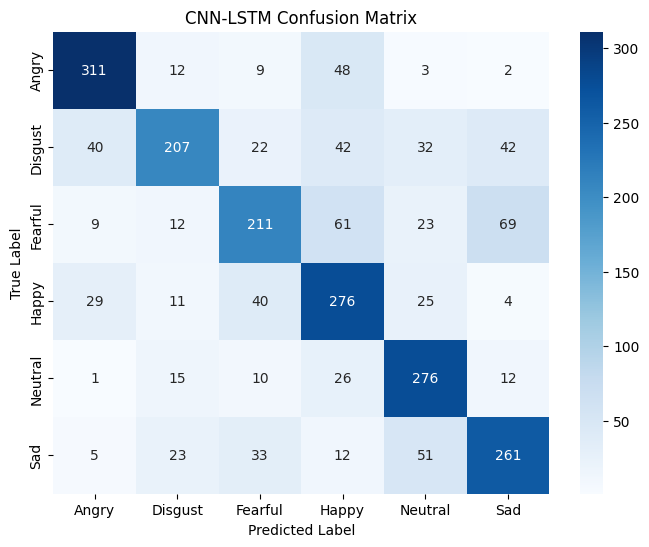

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN-LSTM Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

report_df = pd.DataFrame(report).transpose()

report_df = report_df.round(3)

display(report_df)


,precision,recall,f1-score,support
Angry,0.787,0.808,0.797,385.000
Disgust,0.739,0.538,0.623,385.000
Fearful,0.649,0.548,0.594,385.000
Happy,0.594,0.717,0.649,385.000
Neutral,0.673,0.812,0.736,340.000
Sad,0.669,0.678,0.674,385.000
accuracy,0.681,0.681,0.681,0.681
macro avg,0.685,0.683,0.679,2265.000
weighted avg,0.686,0.681,0.678,2265.000
